In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pickle 
from pathlib import Path

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from utils.filepaths.filepaths import FILE_PATH_FLOW_LOOP_DATA, FILE_PATH_BEST_MODELS_REGRESSION_FEATURE_2,FILE_PATH_MODEL_RESULTS_REGRESSION_FEATURE_2
from utils.datasets.datasets import MLPDataset
from utils.training.training import k_fold_cross_validation, k_fold_cross_validation_sklearn_models
from utils.models.models import MLP
from utils.utils.utils import change_directory
import seaborn as sns 
sns.set_theme()

In [35]:

FILE_PATH_BEST_MODELS = FILE_PATH_BEST_MODELS_REGRESSION_FEATURE_2
BEST_MODEL_PATH = Path("Notebooks","models","nn_on_flow_loop_data_feature_2_no_regula")
DATA_PATH = FILE_PATH_MODEL_RESULTS_REGRESSION_FEATURE_2

In [36]:
with open(FILE_PATH_FLOW_LOOP_DATA, 'r')as file:
    data = file.readlines()
    changed_data = []
    for line in data:
        changed_line = line.strip().split('\t')
        changed_data.append(changed_line)
        

In [37]:
df = pd.DataFrame(data=changed_data[1:], columns = changed_data[0])
df = df.drop(index = 0)

In [38]:
print(df.columns)
df = df[df["Cuttings conc quality"]=='1']
print(df['Inclination'].unique())
print(df['Taylor number'].where(df['Inclination']=='48'))
inclination_mapping = {'90' : 90 * np.pi / 180, '60' : 60*np.pi / 180, '48' : 48 * np.pi / 180}
df["Inclination"] = df["Inclination"].map(inclination_mapping)
fluid_mapping = {'EMSVersatec' : 2.0, 'Glydril': 1.0}
df["Fluid name"] = df["Fluid name"].map(fluid_mapping)
print(df['Inclination'].unique())

Index(['mean File name', 'mean StartTime', 'mean EndTime', 'mean DPT1',
       'mean DPT2', 'mean DPT3', 'mean Torque', 'mean MudDensity',
       'mean Tankweight', 'mean TempTank', 'mean SandRate', 'mean Flow',
       'mean DPT4', 'mean DPR1', 'mean DPR2', 'mean TestSectionWeight',
       'mean SetPoint', 'mean USL', 'mean StringRPM',
       'mean relBedHeightTankWeight', 'mean relBedHeightTestSectionWeight',
       'mean fricCoeff', 'std DPT1', 'std DPT2', 'std DPT3', 'std Torque',
       'std MudDensity', 'std Tankweight', 'std TempTank', 'std SandRate',
       'std Flow', 'std DPT4', 'std DPR1', 'std DPR2', 'std TestSectionWeight',
       'std SetPoint', 'std USL', 'std StringRPM',
       'std relBedHeightTankWeight', 'std relBedHeightTestSectionWeight',
       'std fricCoeff', 'drift DPT1', 'drift DPT2', 'drift DPT3',
       'drift Torque', 'drift MudDensity', 'drift Tankweight',
       'drift TempTank', 'drift SandRate', 'drift Flow', 'drift DPT4',
       'drift DPR1', 'drift DPR

In [39]:
# No flow behavior index since I am not sure if I can use that for field data
# Friction coefficient had many nan values. See what to do about this later
# Might not need it as you probably do not have it for field
print(df["Eccentricity"].unique())
dict_of_variables = {
    "$dp / dx}$" : df["dpdx DPR2"].astype('float32'),
    # "$H_{rel}$" : df["mean relBedHeightTestSectionWeight"].astype('float32'),
    # "$\mathrm{S_p}$" : df["Particle slip ratio in test section"].astype('float32'),
    "$\epsilon$" : df["Eccentricity"].astype("float32"),
    r"$\beta$" : df["Inclination"],
    "$Re$" : df["Reynolds annulus (no cuttings)"].astype("float32"),
    "$Sh$" : df["Shields number"].astype("float32"),
    "$Ta$" : df["Taylor number"].astype("float32"),
    "Fluid type": df["Fluid name"],
    # "Froude" : df["Froude number"].astype("float32"),
    # 'Reynolds by Bingham' : df["Reynolds annulus (no cuttings)"].astype("float32") * df["Bingham number"].astype("float32"),
    '$Bh$' : df["Bingham number"].astype("float32"),
    '$f$' : df["Friction factor mod annulus"].astype("float32"),
    # 'Reynolds by taylor' : df["Reynolds annulus (no cuttings)"].astype("float32") / df["Taylor number"].astype("float32")
    # "Friction coef" : df["mean fricCoeff"].astype("float32"),
}
df = pd.DataFrame(dict_of_variables)
# df = df[(df.drop(columns=["Inclination"])>0).all(axis=1)]
df = df[(df>0).all(axis = 1)]

['1' '0.5']


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\thomaswi\AppData\Local\Temp\ipykernel_10624\2670983343.py:8: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon$" : df["Eccentricity"].astype("float32"),


In [40]:
# Encoding fluid categorically
fluid_mapping = {'EMSVersatec' : 1.0, 'Glydril': 0.0}
# df["Fluid name"] = df["Fluid name"].map(fluid_mapping)
# Likewise for inclination



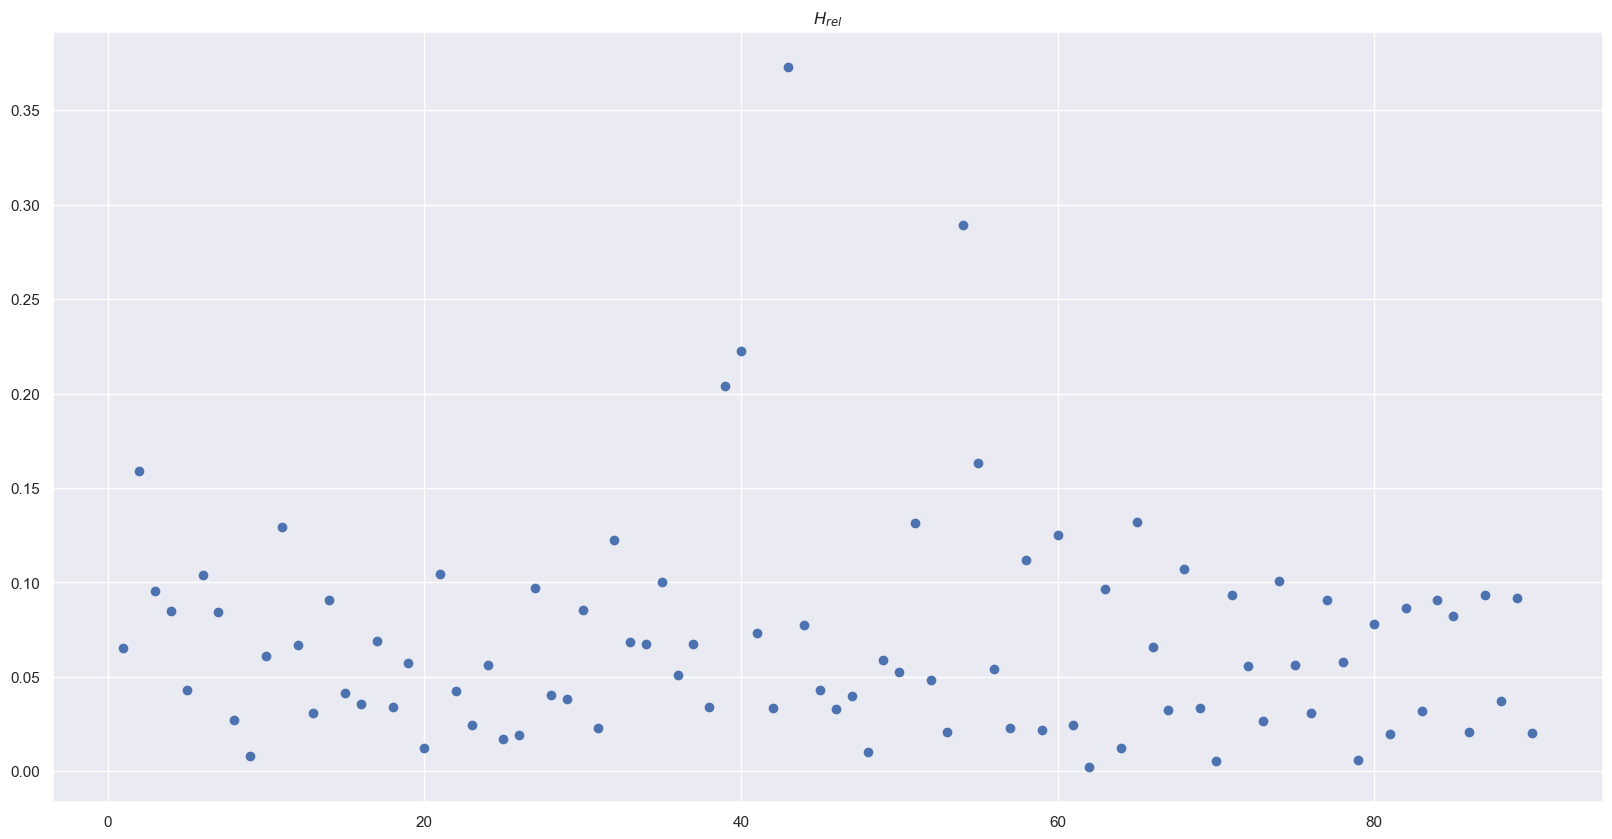

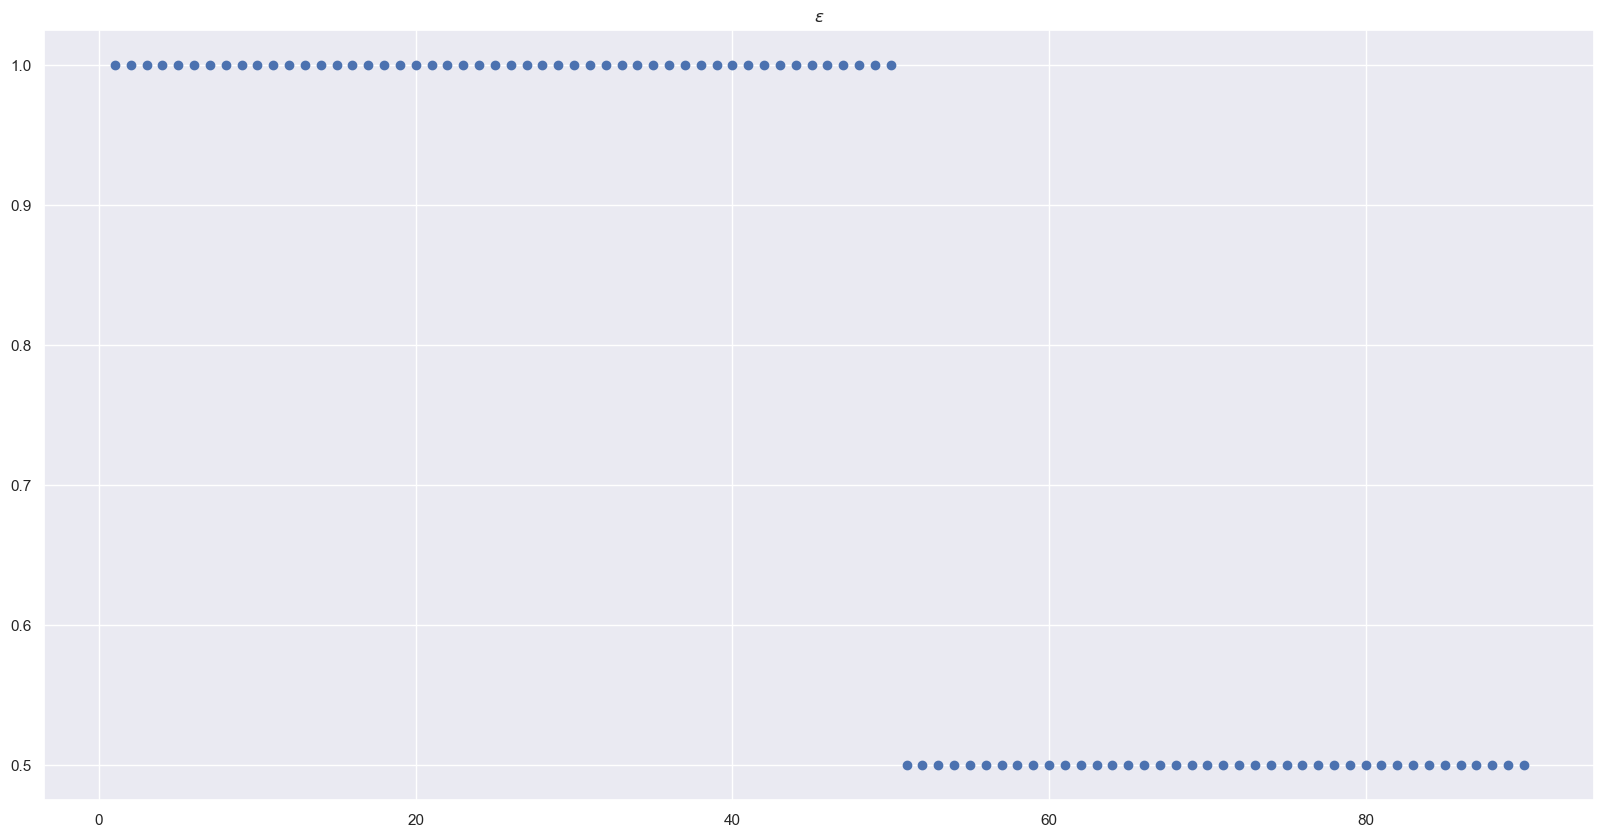

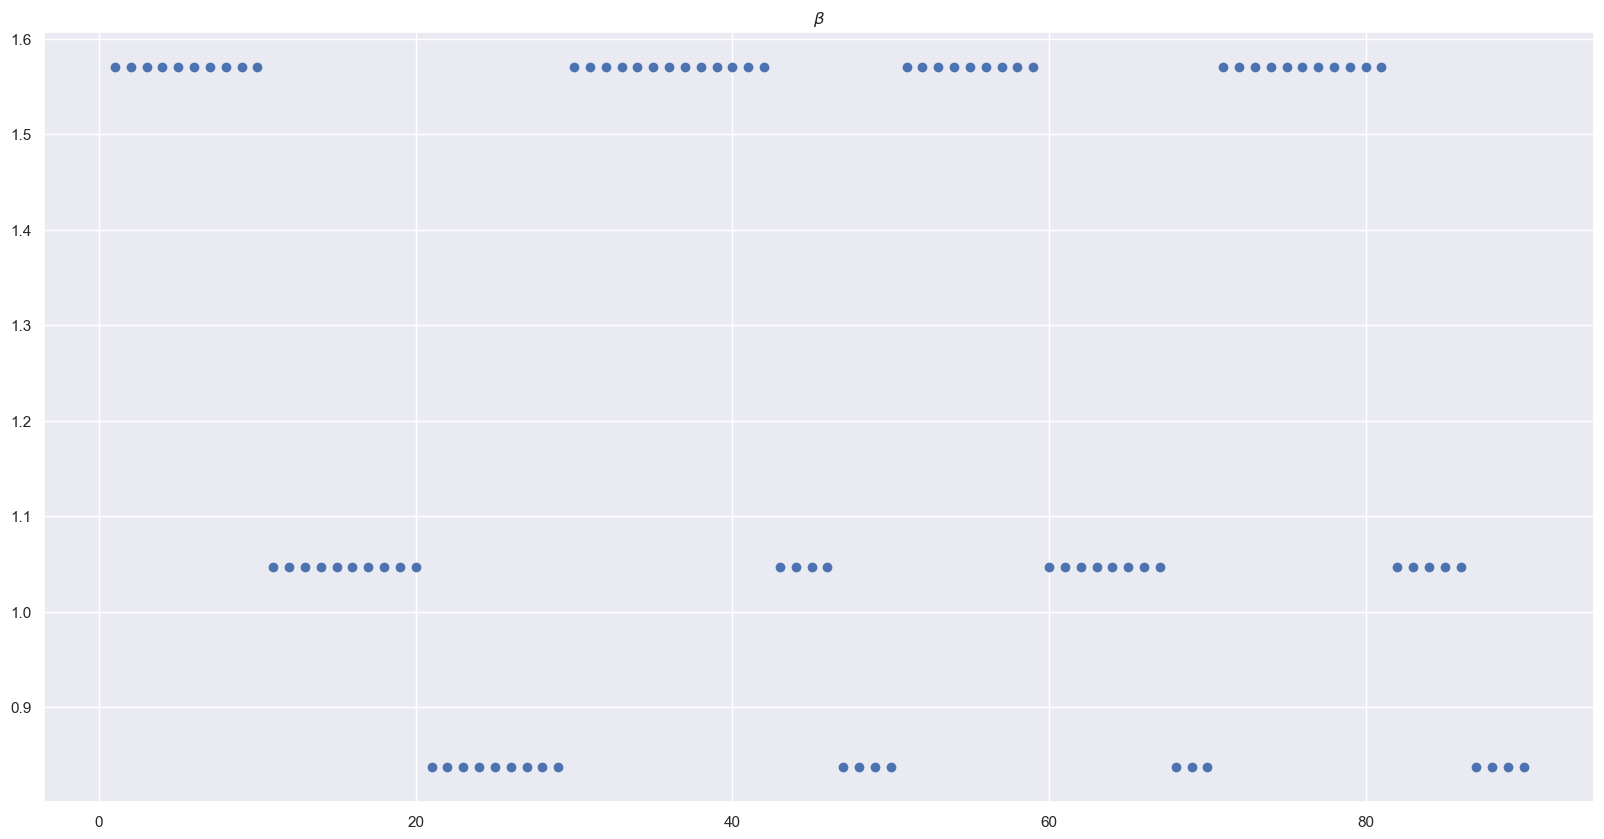

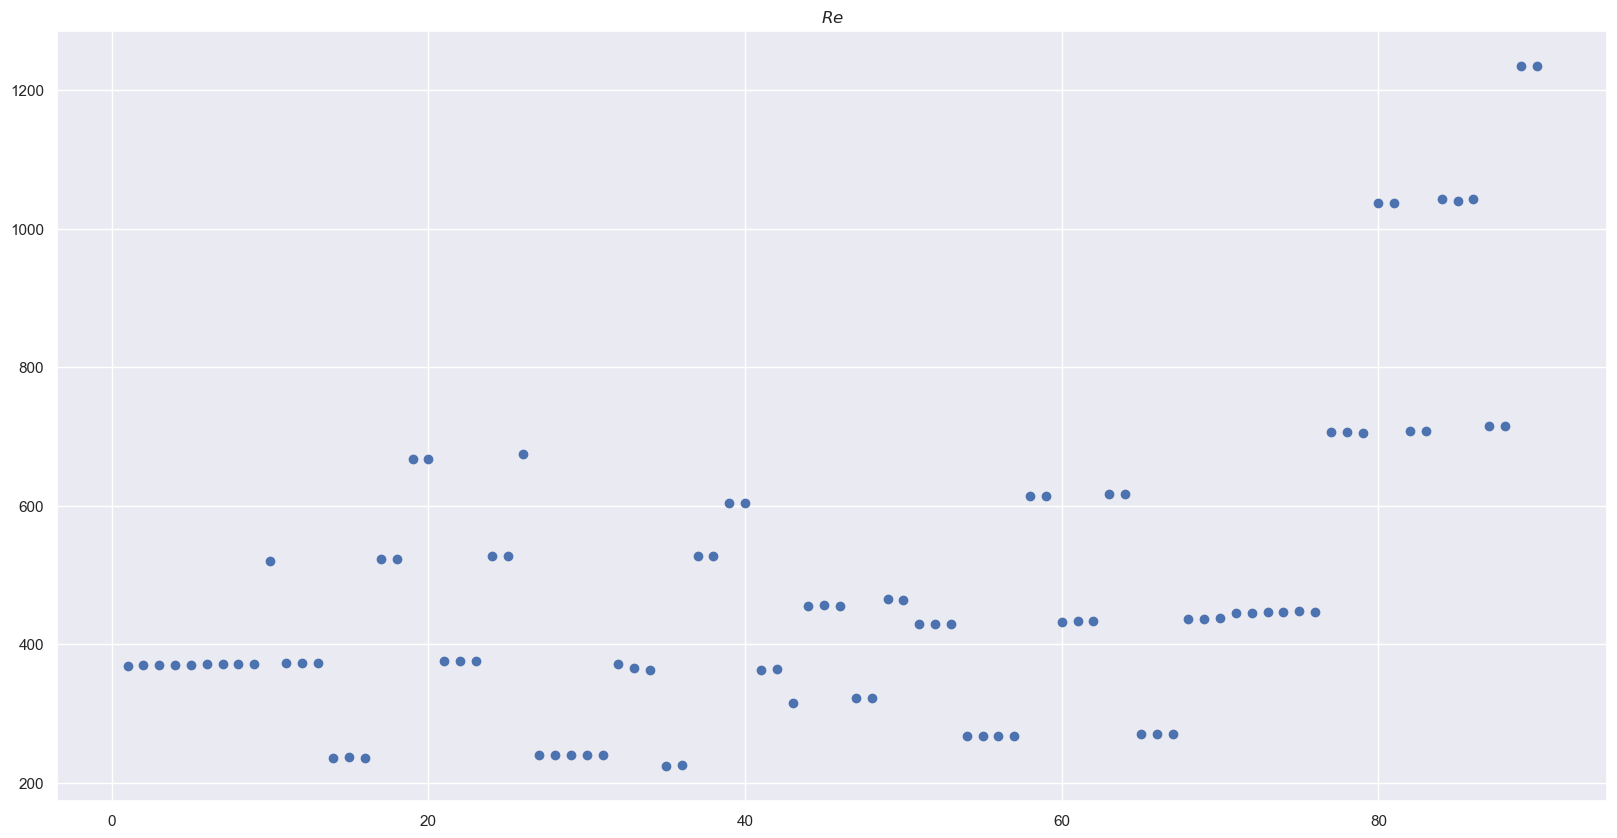

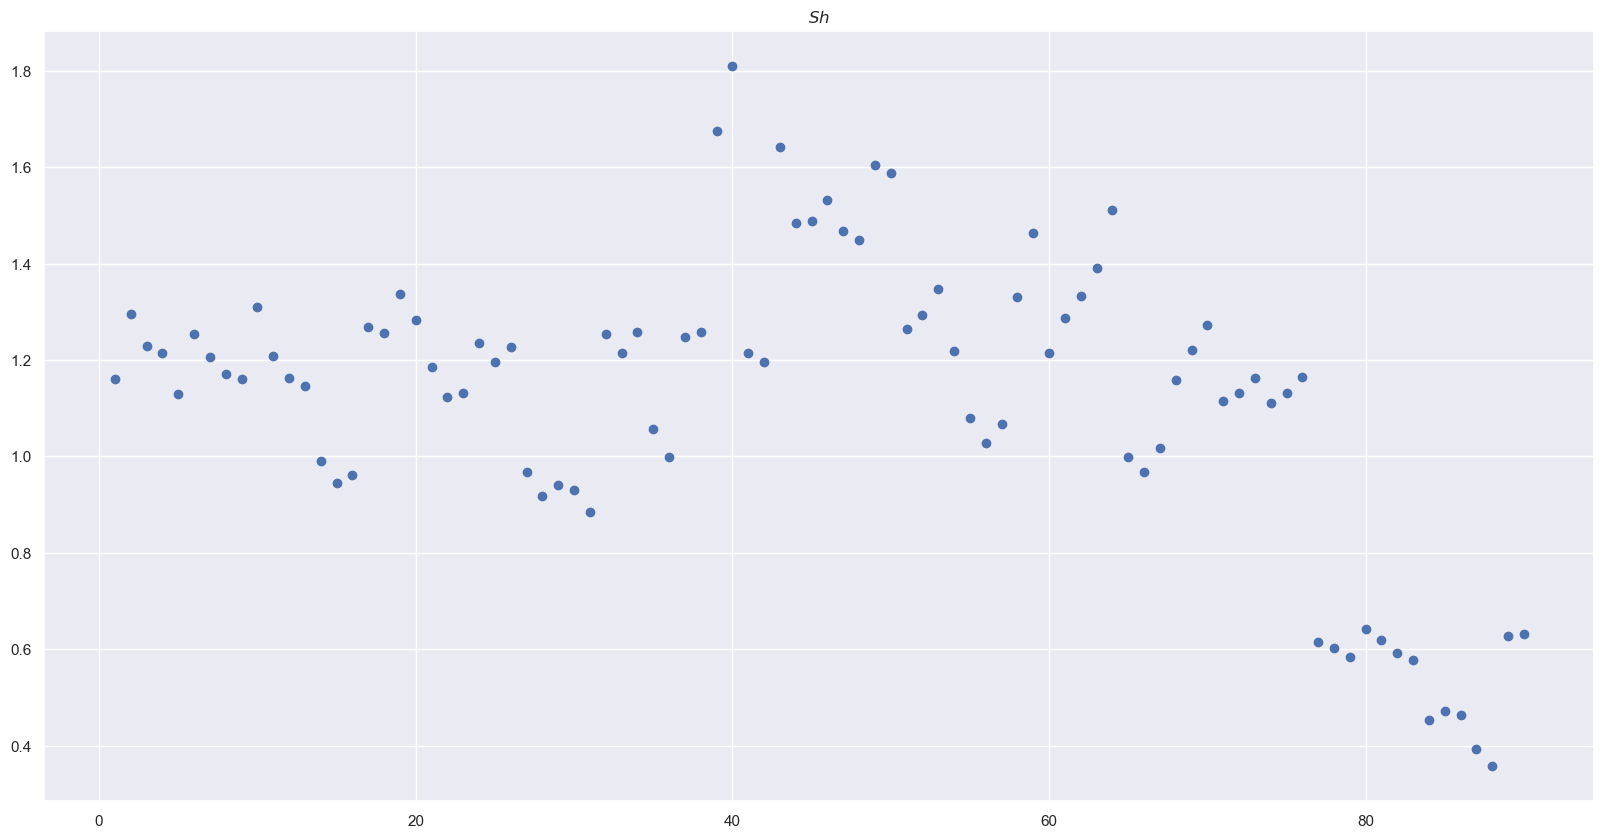

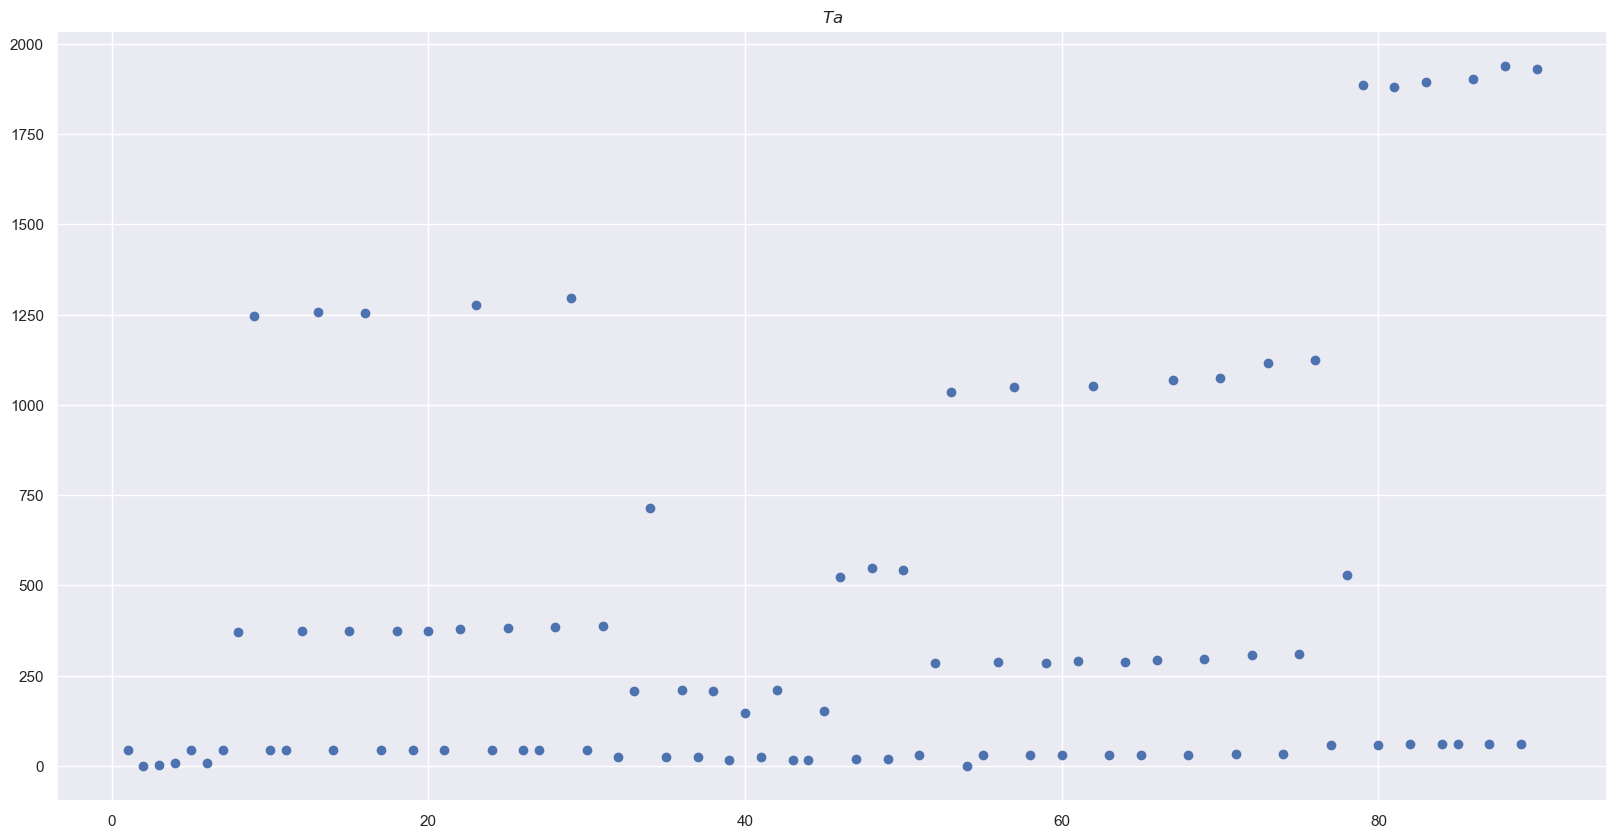

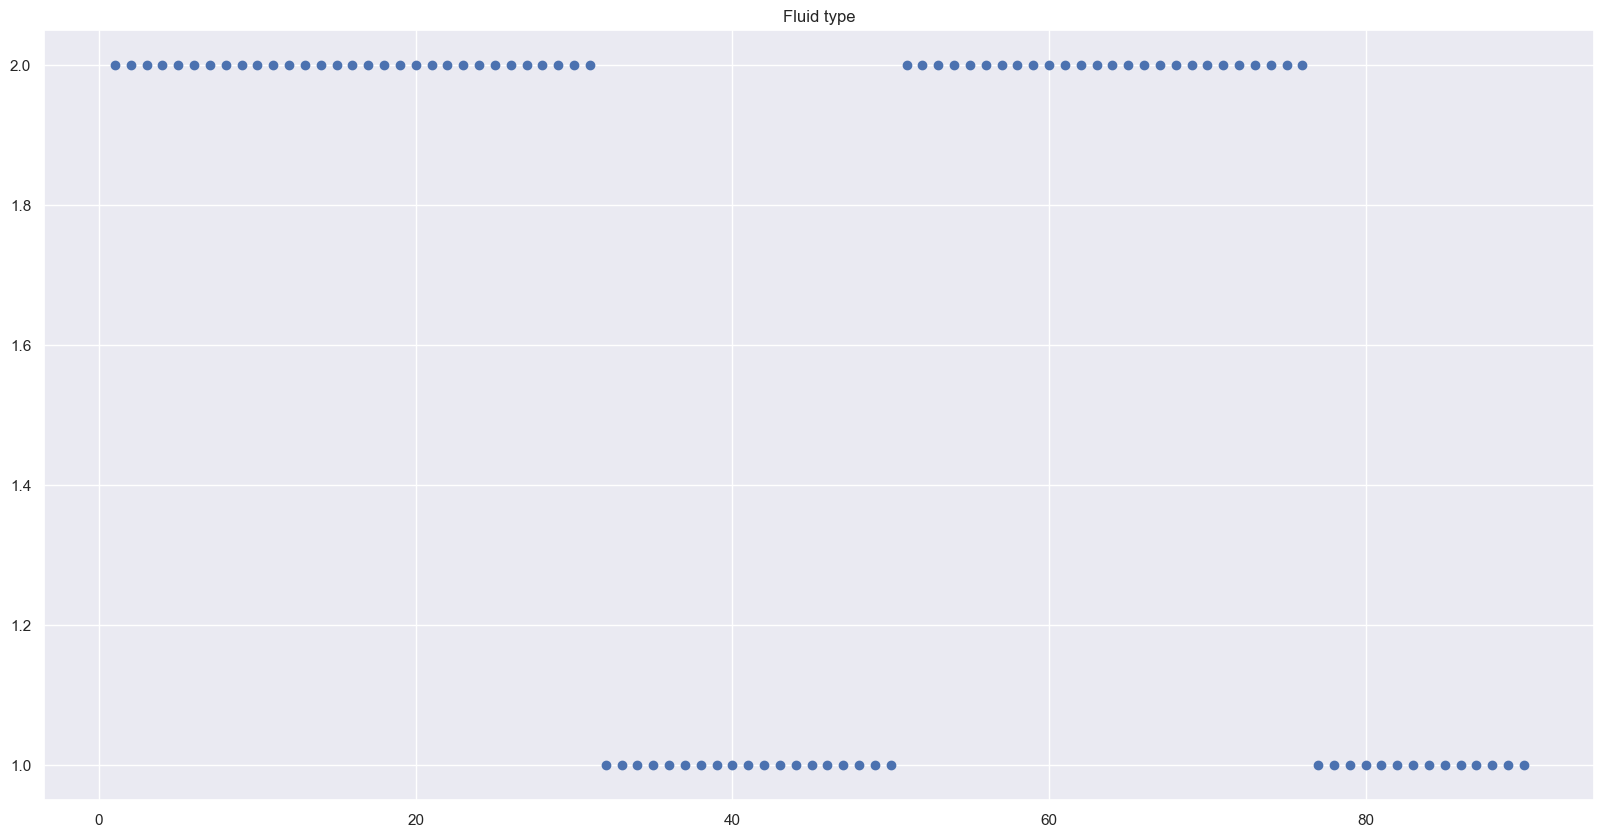

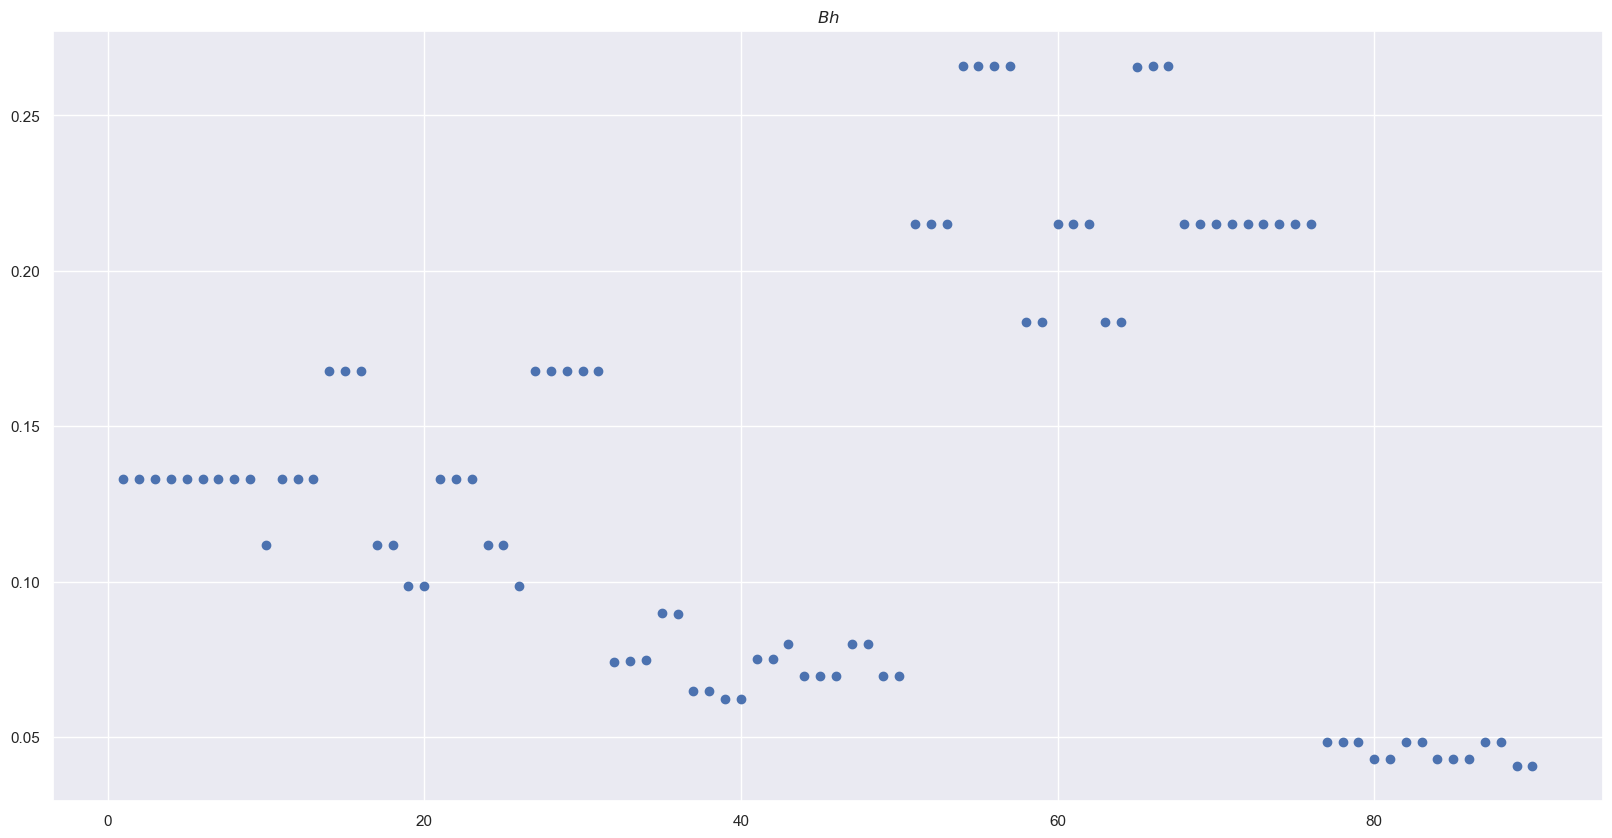

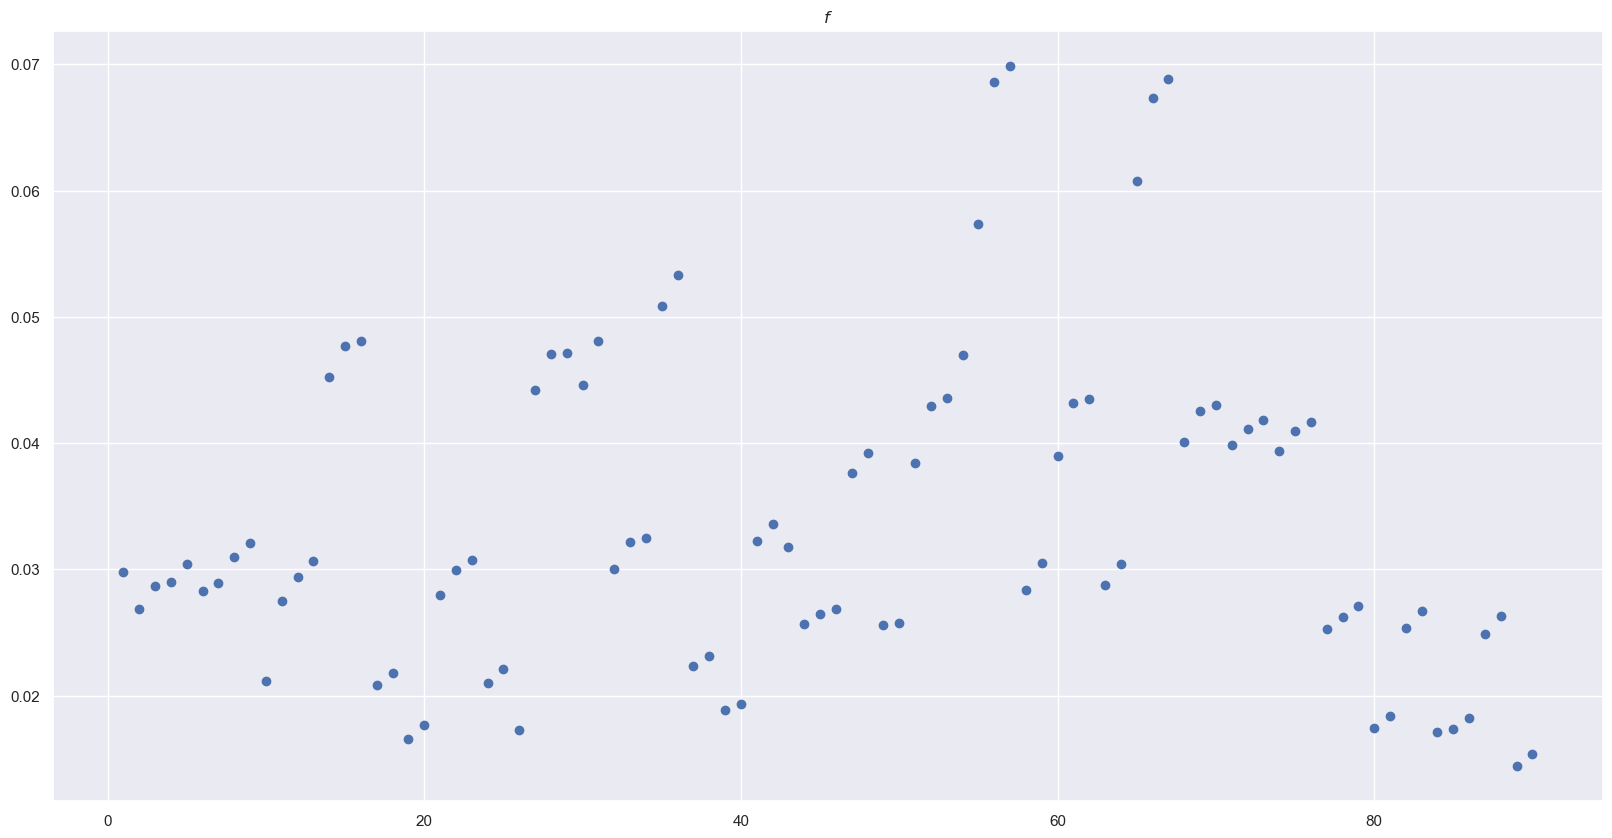

In [41]:
x_points = np.arange(1, len(df)+1,1)
for column in df:
    plt.figure(figsize=(20,10))
    plt.title(column)
    plt.scatter(x_points,df[column].values)
    plt.show()

In [42]:
df = df.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [43]:
print(df.isna().sum())

$H_{rel}$     0
$\epsilon$    0
$\beta$       0
$Re$          0
$Sh$          0
$Ta$          0
Fluid type    0
$Bh$          0
$f$           0
dtype: int64


In [44]:

param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],   # Inverse of regularization strength
    'solver': ['newton-cholesky', 'newton-cg', 'lbfgs','sag','saga'],  # Optimization algorithm
    'penalty': [None, 'l2'],  # Regularization type (Note: 'l1' is only compatible with 'liblinear' and 'saga')
    'max_iter': [100, 200],  # Number of iterations
    'tol': [1e-4, 1e-3]  # Tolerance
}

param_grid_rf = {
    'n_estimators': [50,100,150,250,500,1000],
    'max_depth': [5,6,7,8,9,10,11,12,13,14],
    'min_samples_split': [2,3,4,5],                   # Minimum samples required to split a node
    'min_samples_leaf': [ 2,3,4,5],                     # Minimum samples required at a leaf node
    'bootstrap': [True],
    'criterion' : ['squared_error'],
    'max_features' : ['log2','sqrt']
}

param_grid_svc = { 
    'C': [1e-2, 0.1, 1.0,100,1000],
    'gamma': [1e-4, 1e-3, 1e-2,1e-1,1],
    'kernel' : ['rbf','linear','poly'],
}


param_grid_xg = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'min_child_weight' : [1,2,3,4,5]}

In [45]:
target_column = "$dp / dx$"
n_splits = 5
k_fold_outer = KFold(n_splits = n_splits, shuffle = True, random_state = 42)
k_fold_inner = KFold(n_splits = n_splits, shuffle = True, random_state = 42)
data_k_fold_nn, best_fold_nn, avg_mse_nn = k_fold_cross_validation(df=df, split_percentage = 0.9, n_splits = n_splits,hidden_size=128, batch_size = 8, num_epochs = 120, model_path=BEST_MODEL_PATH, learning_rate = 1e-3, kfold=k_fold_outer,target_column=target_column, task = 'regression', criterion=nn.MSELoss(),weight_decay=0.0, dropout = 0.0, z_score = True)


# data_k_fold_xg, best_fold_xg, best_model_xg,avg_mse_xg= k_fold_cross_validation_sklearn_models(df=df,split_percentage=0.9,model=XGBRegressor,n_splits=n_splits,kfold_outer=k_fold_outer, kfold_inner=k_fold_inner, param_grid=param_grid_xg, target_column=target_column,task = "regression", z_score = True)
data_k_fold_rf, best_fold_rf, best_model_rf,avg_mse_rf= k_fold_cross_validation_sklearn_models(df=df,split_percentage=0.9,model=RandomForestRegressor,n_splits=n_splits,kfold_outer=k_fold_outer, kfold_inner=k_fold_inner, param_grid=param_grid_rf, target_column=target_column,task = "regression", z_score = True)
# data_k_fold_svc, best_fold_svc, best_model_svc,avg_mse_svc = k_fold_cross_validation_sklearn_models(df=df,split_percentage=0.9,model=SVR,n_splits=n_splits,kfold_outer=k_fold_outer, kfold_inner=k_fold_inner, param_grid=param_grid_svc, target_column=target_column,task = "regression", z_score = True)

Training for fold 1...
Training...
Saving best model for epoch 1 with loss 0.0367615
Saving best model for epoch 2 with loss 0.0279932
Saving best model for epoch 3 with loss 0.0173600
Saving best model for epoch 4 with loss 0.0153934
Saving best model for epoch 5 with loss 0.0148873
Saving best model for epoch 7 with loss 0.0140313
Saving best model for epoch 10 with loss 0.0129576
Saving best model for epoch 18 with loss 0.0128109
Saving best model for epoch 20 with loss 0.0125740
Saving best model for epoch 28 with loss 0.0123618
Saving best model for epoch 30 with loss 0.0115667
Saving best model for epoch 38 with loss 0.0113726
Saving best model for epoch 40 with loss 0.0113172
Saving best model for epoch 44 with loss 0.0107611
Saving best model for epoch 57 with loss 0.0104900
Saving best model for epoch 70 with loss 0.0095677
Training for fold 2...
Training...
Saving best model for epoch 1 with loss 0.0143134
Saving best model for epoch 2 with loss 0.0135542
Saving best model fo

5it [16:00, 192.09s/it]

Best model found for fold: 5 with mse of 0.0004011 average mse is:  0.0021843413559123675


In [46]:

data = {'Neural network' : data_k_fold_nn,
        # 'XGBoost' : data_k_fold_xg,
        'Random forest' : data_k_fold_rf,
        # 'Svc' : data_k_fold_sv
        }

In [47]:
print(f'Average mse for nn: {avg_mse_nn}')
# print(f'Average mse for xg: {avg_mse_xg}')
print(f'Average mse for rf: {avg_mse_rf}')
# print(f'Average mse for svc: {avg_mse_svc}')



Average mse for nn: 0.0022851944086141884
Average mse for rf: 0.0021843413559123675


In [48]:
print(f'The testing mse for the neural network is: {data_k_fold_nn["Test loss"]}')
# print(f'The testing mse for the xgboost is: {data_k_fold_xg["Test mse"]}')
print(f'The testing mse for the rf is: {data_k_fold_rf["Test mse"]}')
# print(f'The testing mse for the svc is: {data_k_fold_svc["Test mse"]}')

The testing mse for the neural network is: 0.00031094756559468806
The testing mse for the rf is: 0.00022085847994319214


In [49]:
best_model_params = {
'best_params_rf' : best_model_rf.get_params()}

In [50]:
for key, value in best_model_params.items():
    print(f'{key} are {value}')

best_params_rf are {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [51]:
# path = FILE_PATH_BEST_MODELS
# with path.open('wb') as file:
#     pickle.dump(best_model_params,file)
# path_data = DATA_PATH
# with path_data.open('wb') as file:
#     pickle.dump(data,file)

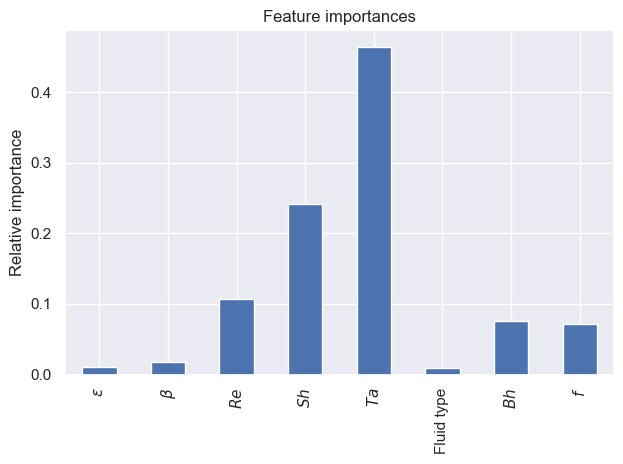

In [52]:
name_features = df.drop(columns = "$H_{rel}$").columns
importances = best_model_rf.feature_importances_

forest_importances = pd.Series(importances, index = name_features)
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances")
ax.set_ylabel("Relative importance")
fig.tight_layout()

In [53]:
def print_every_fold_validation(data_k_fold):
    metrics = []
    for idx in range(1,6):
        mse = data_k_fold[f"Fold {idx}"]["MSE"]
        metrics.append(mse)
    for idx, mse in enumerate(metrics):
        print('Mse for fold: ',idx +1, '  ', mse)
    print(f'Average mse: {np.mean(metrics)} and std {np.std(metrics)}')
    return np.mean(metrics), np.std(metrics)

In [54]:
mean_nn, std_nn = print_every_fold_validation(data_k_fold_nn)
mean_rf, std_rf = print_every_fold_validation(data_k_fold_rf)

Mse for fold:  1    0.0050935037434101105
Mse for fold:  2    0.0006149719702079892
Mse for fold:  3    0.0013104857644066215
Mse for fold:  4    0.00021286221453920007
Mse for fold:  5    0.004194148350507021
Average mse: 0.0022851944086141884 and std 0.0019781287687922772
Mse for fold:  1    0.005800577910684726
Mse for fold:  2    0.000840372238227171
Mse for fold:  3    0.0029930968501856413
Mse for fold:  4    0.000886602722669515
Mse for fold:  5    0.0004010570577947867
Average mse: 0.0021843413559123675 and std 0.0020199868171354154


In [55]:
from scipy.stats import skew, kurtosis
skewness_nn = skew(data_k_fold_nn["Test targets"].numpy() - data_k_fold_nn["Test preds"].numpy())
kurt_nn = kurtosis(data_k_fold_nn["Test targets"].numpy() - data_k_fold_nn["Test preds"].numpy())
# skewness_xg = skew(data_k_fold_xg["Test targets"] - data_k_fold_xg["Test preds"])
# kurt_xg = kurtosis(data_k_fold_xg["Test targets"] - data_k_fold_xg["Test preds"])
skewness_rf = skew(data_k_fold_rf["Test targets"] - data_k_fold_rf["Test preds"])
kurt_rf = kurtosis(data_k_fold_rf["Test targets"] - data_k_fold_rf["Test preds"])
# skewness_svc = skew(data_k_fold_svc["Test targets"] - data_k_fold_svc["Test preds"])
# kurt_svc = kurtosis(data_k_fold_svc["Test targets"] - data_k_fold_svc["Test preds"])

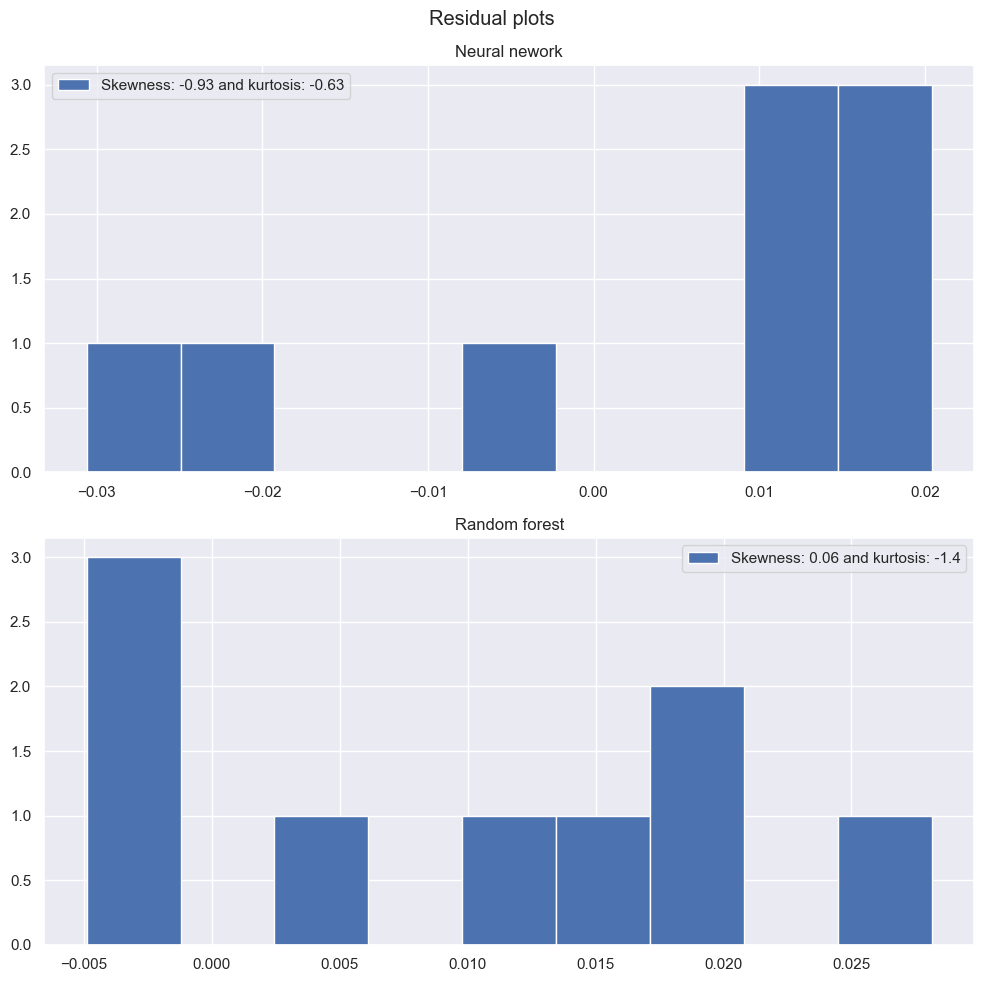

In [56]:
fig, ax = plt.subplots(2, figsize = (10,10))
fig.suptitle("Residual plots")
ax[0].set_title("Neural nework")
ax[0].hist(data_k_fold_nn["Test targets"] - data_k_fold_nn["Test preds"], bins = 9, label = f'Skewness: {np.round(skewness_nn.item(),2)} and kurtosis: {np.round(kurt_nn.item(),2)}')
ax[0].legend()
# ax[0,1].set_title("XGBoost")
# ax[0,1].hist(data_k_fold_xg["Test targets"] - data_k_fold_xg["Test preds"],bins = 9, label = f'Skewness: {np.round(skewness_xg,2)} and kurtosis: {np.round(kurt_xg,2)}')
# ax[0,1].legend()
ax[1].set_title("Random forest")
ax[1].hist(data_k_fold_rf["Test targets"] - data_k_fold_rf["Test preds"], bins = 9, label = f'Skewness: {np.round(skewness_rf,2)} and kurtosis: {np.round(kurt_rf,2)}')
ax[1].legend()
# ax]1].set_title("Support vector machine")
# ax[1,1].hist(data_k_fold_svc["Test targets"] - data_k_fold_svc["Test preds"],bins = 9, label = f'Skewness: {np.round(skewness_svc,2)} and kurtosis: {np.round(kurt_svc,2)}')
# ax[1,1].legend()

plt.tight_layout()

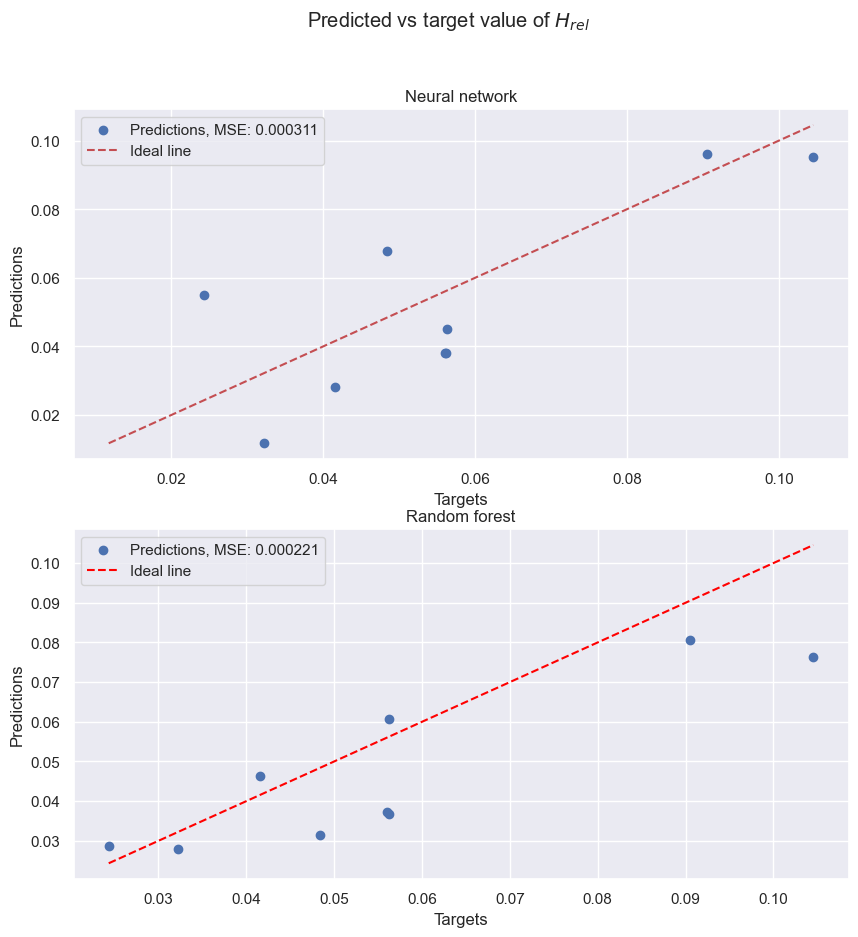

In [57]:
x_scatter = np.arange(0,len(data_k_fold_nn["Test targets"]),1)
fig,ax = plt.subplots(2, figsize = (10,10))
fig.suptitle("Predicted vs target value of $H_{rel}$")
ax[0].set_title("Neural network")
ax[0].scatter(data_k_fold_nn["Test targets"],data_k_fold_nn["Test preds"], color = 'C0',label = f'Predictions, MSE: {np.round(data_k_fold_nn['Test loss'],6)}')
min_val = min(min(data_k_fold_nn["Test targets"]), min(data_k_fold_nn["Test preds"]))
max_val = max(max(data_k_fold_nn["Test targets"]), max(data_k_fold_nn["Test preds"]))
ax[0].plot([min_val, max_val], [min_val, max_val], color="C3", linestyle="--", label="Ideal line")
ax[0].set_ylabel("Predictions")
ax[0].set_xlabel("Targets")
ax[0].legend()

# ax[0,1].set_title("XGBoost")
# ax[0,1].scatter(x_scatter,data_k_fold_xg["Test targets"], color = 'C0', label = 'Target')
# ax[0,1].scatter(x_scatter,data_k_fold_xg["Test preds"], color = 'C1', label = ' Prediction')
# ax[0,1].legend()
ax[1].set_title("Random forest")
ax[1].scatter(data_k_fold_rf["Test targets"],data_k_fold_rf["Test preds"], color = 'C0', label = f'Predictions, MSE: {np.round(data_k_fold_rf['Test mse'],6)}')
min_val = min(min(data_k_fold_rf["Test targets"]), min(data_k_fold_rf["Test preds"]))
max_val = max(max(data_k_fold_rf["Test targets"]), max(data_k_fold_rf["Test preds"]))
ax[1].plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Ideal line")
ax[1].set_ylabel("Predictions")
ax[1].set_xlabel("Targets")
ax[1].legend()
# ax[1,1].set_title("Support vector machine")
# ax[1,1].scatter(x_scatter,data_k_fold_svc["Test targets"], color = 'C0', label = 'Target')
# ax[1,1].scatter(x_scatter,data_k_fold_svc["Test preds"], color = 'C1', label = ' Prediction')
# ax[1,1].legend()


In [58]:
print("Testing mse for nn: ", data_k_fold_nn["Test loss"])
# print("Testing mse for xg: ", data_k_fold_xg["Test mse"])
print("Testing mse for rf: ", data_k_fold_rf["Test mse"])
# print("Testing mse for svc: ", data_k_fold_svc["Test mse"])

Testing mse for nn:  0.00031094756559468806
Testing mse for rf:  0.00022085847994319214


In [59]:
test_features_nn = data_k_fold_nn["Test features"]
test_features_rf = data_k_fold_rf["Test features"]
test_targets_nn = data_k_fold_nn["Test targets"]
test_targets_rf = data_k_fold_rf["Test targets"]
test_preds_nn = data_k_fold_nn["Test preds"]
test_preds_rf = data_k_fold_rf["Test preds"]

In [60]:
print(len(test_features_rf))

9


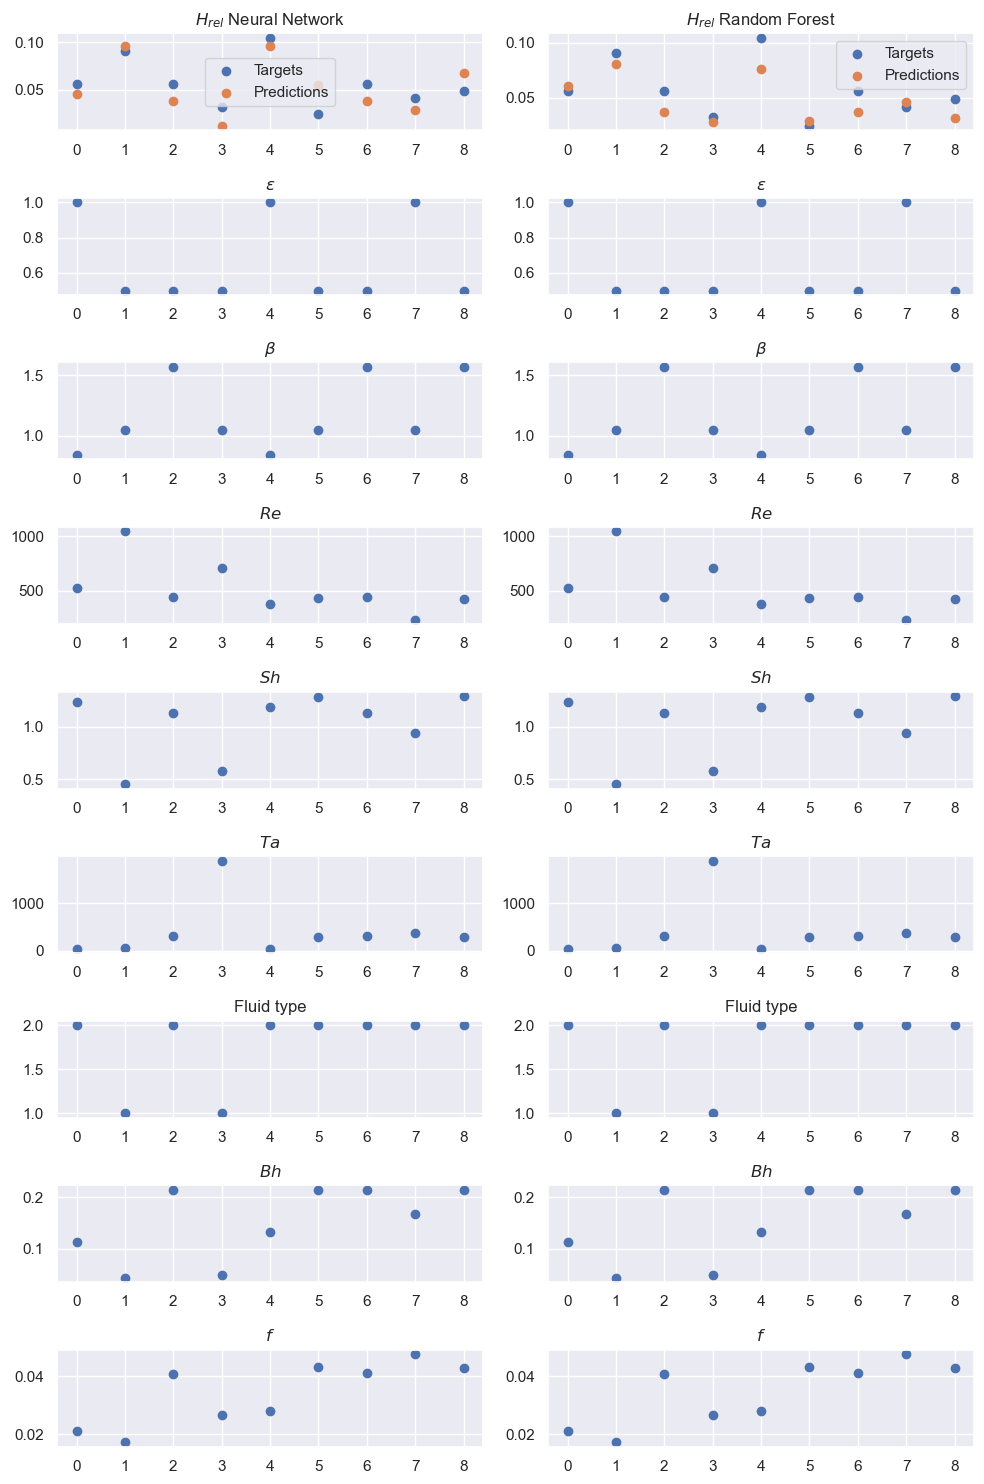

In [61]:
# columns = df.drop(columns = "$\H_{rel}$").columns
fig, ax = plt.subplots(len(name_features) + 1, 2, figsize = (10,15))
x_vals_for_plot = np.arange(0,len(test_features_nn), 1)
ax[0,0].set_title("$H_{rel}$ Neural Network")
ax[0,0].scatter(x_vals_for_plot, test_targets_nn, label = 'Targets',color = "C0")
ax[0,0].scatter(x_vals_for_plot, test_preds_nn, label = 'Predictions', color = "C1")
ax[0,0].legend()

ax[0,1].set_title("$H_{rel}$ Random Forest")
ax[0,1].scatter(x_vals_for_plot, test_targets_rf, label = 'Targets',color = "C0")
ax[0,1].scatter(x_vals_for_plot, test_preds_rf, label = 'Predictions', color = "C1")
ax[0,1].legend()
for idx,column in enumerate(name_features):
    ax[idx +1,0].set_title(column)
    ax[idx +1,0].scatter(x_vals_for_plot, test_features_nn[:,idx])
    ax[idx +1,1].set_title(column)
    ax[idx +1,1].scatter(x_vals_for_plot, test_features_rf[:,idx])
plt.tight_layout()

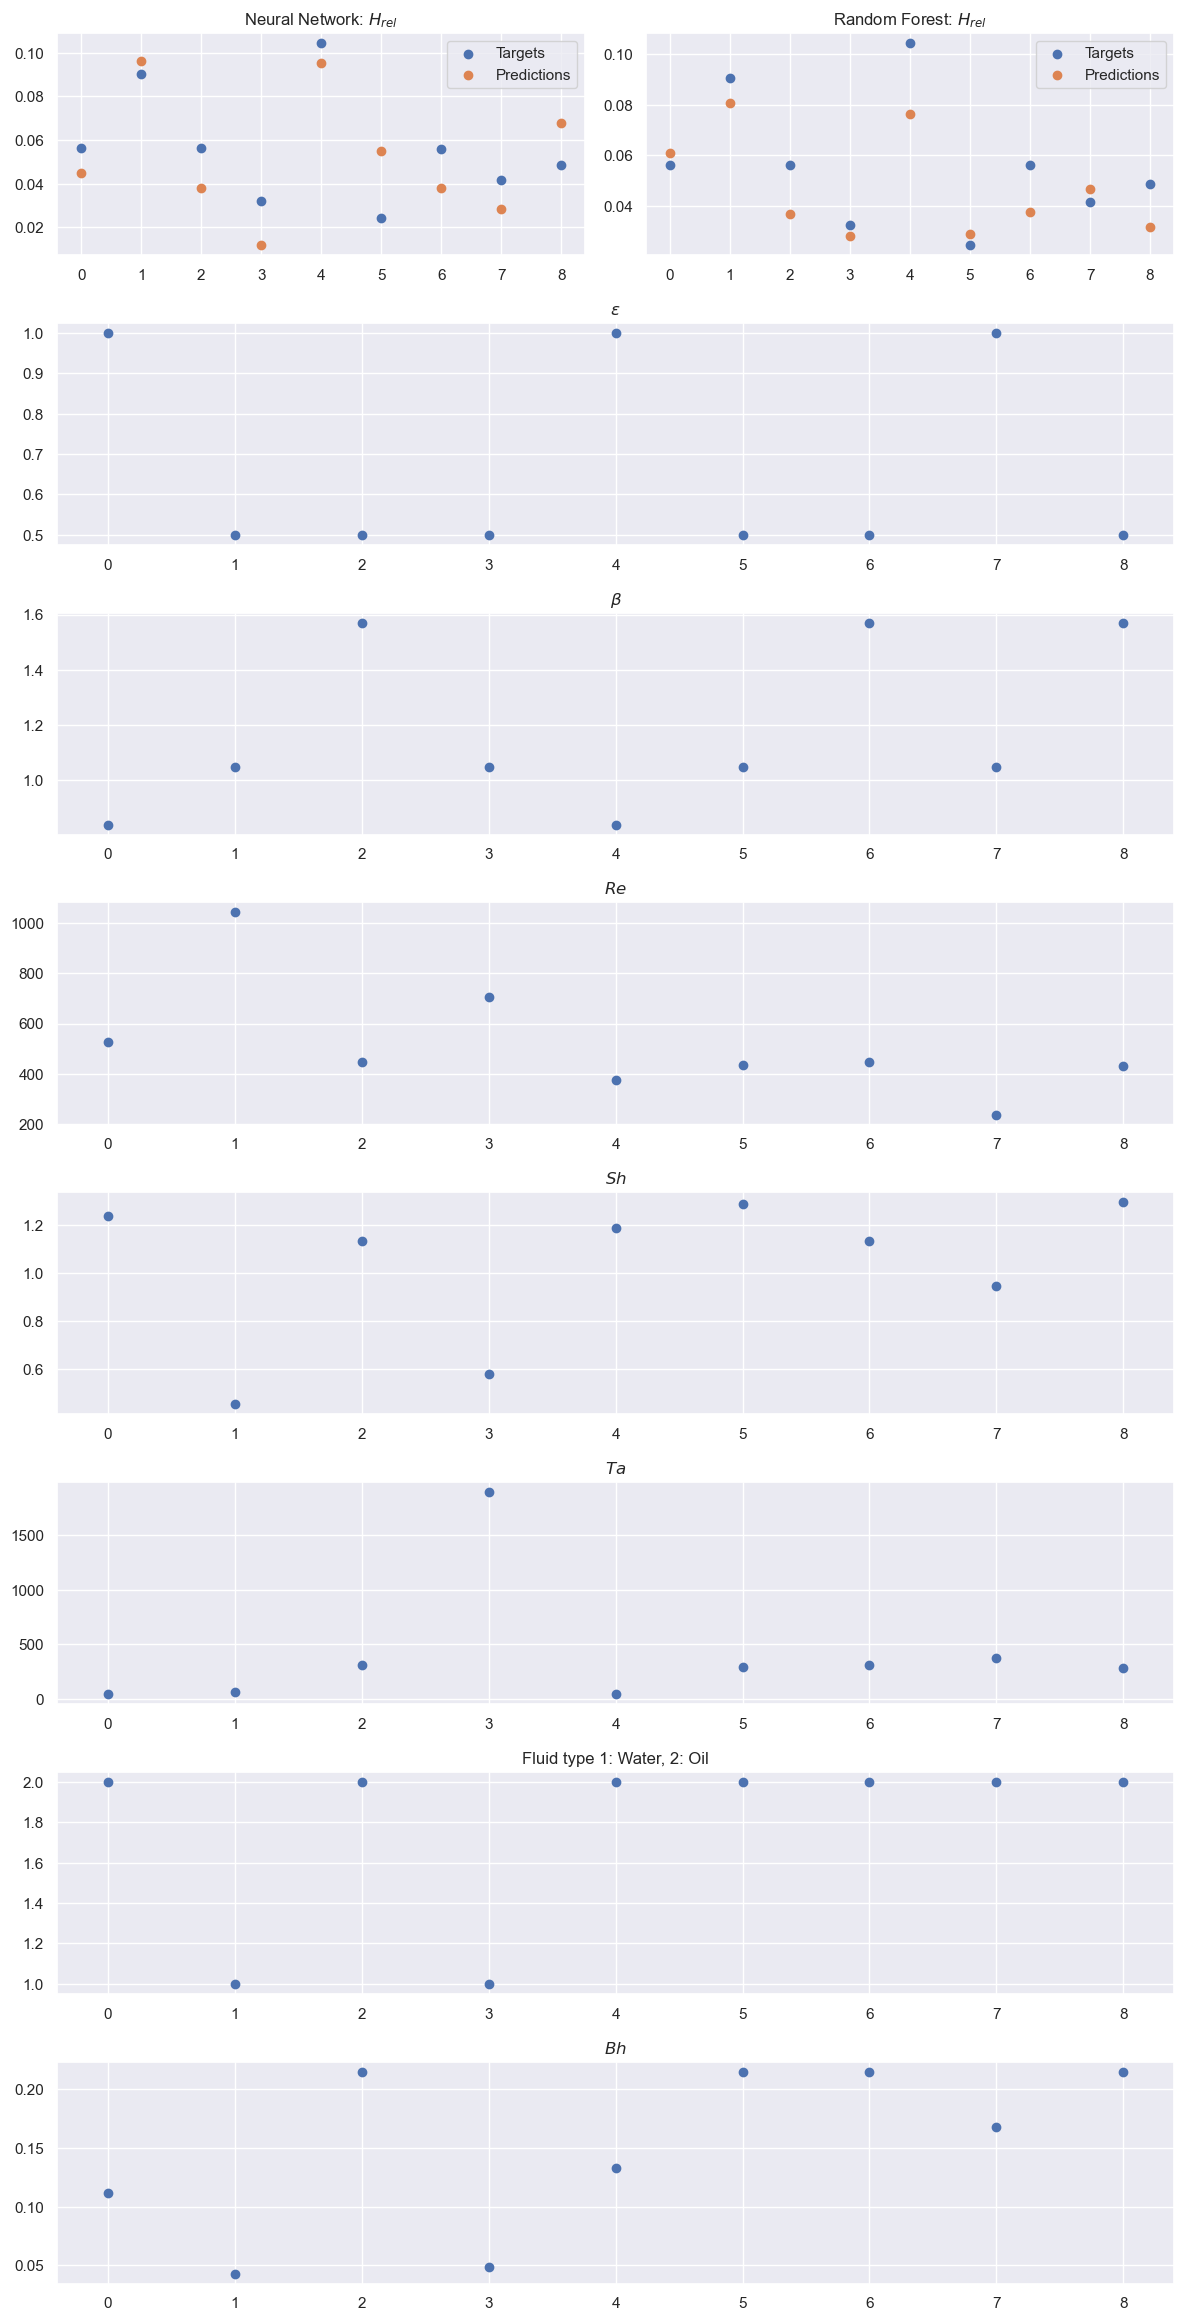

In [64]:
import matplotlib.gridspec as gs
fig = plt.figure(figsize = (12,26))
g = gs.GridSpec(len(name_features) + 1, 2)
ax1 = fig.add_subplot(g[0,0])
ax2 = fig.add_subplot(g[0,1])
axes = [fig.add_subplot(g[i, :]) for i in range(1, len(name_features))]

ax1.set_title("Neural Network: $H_{rel}$ ")
ax1.scatter(x_vals_for_plot, test_targets_nn, label = "Targets")
ax1.scatter(x_vals_for_plot, test_preds_nn, label = 'Predictions')
ax1.legend()
ax2.set_title("Random Forest: $H_{rel}$")
ax2.scatter(x_vals_for_plot, test_targets_rf, label = 'Targets')
ax2.scatter(x_vals_for_plot, test_preds_rf, label = 'Predictions')
ax2.legend()

for idx,ax in enumerate(axes):
    title = name_features[idx]  
    if title == "Fluid type":
        title = title + " 1: Water, 2: Oil"
    ax.set_title(title)
    ax.scatter(x_vals_for_plot, test_features_nn[:,idx])
plt.tight_layout()
